In [1]:
import pandas as pd
import numpy as np
from metalib import metaga_for_test
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [2]:
from metalib.utils import split_dataframe, load_hist_data

## MetaGA Update
Let's try different symbols and assess how is the XGBClassifier + Calibrated CV using isotonic regression.
But first, what is isotonic regression ? How is it used here ?

## What the analysis should yield ?

- Is it better to fine-tune the length of the long/medium/short factors for each symbols or is it ok to use the same ?
- Should you subsample returns to predict/focus on tails ?
- Should you make one model for long predictions ? and one for short ?

If we can answer those, think we can get to a predict good level on this strategy.

In [3]:
price_df = load_hist_data("EURUSD", 2023)

C:\Users\Trismegist\anaconda3\envs\adonys\lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [17]:
ins_list, ous_list = split_dataframe(price_df, insample_days=66, outsample_days=66)
ins, ous = ins_list[0], ous_list[0]

In [25]:
strategy = metaga_for_test.MetaGA(   high_length= 1440,
                            low_length= 60,
                            mid_length= 480,
                            prob_bound= 0.5,
                            size_position= 0.08,
                            symbols=["EURUSD"],
                            tag="metaga_test",
                            timeframe="mt5.TIMEFRAME_M1",
                            active_hours=None
                            )

In [26]:
strategy.data = {"EURUSD": ins}

In [27]:
strategy.prob_bound

0.5

In [28]:
strategy.fit()

metaga_test::: Computed rolling volatilies
metaga_test::: Computed rolling skewness
metaga_test::: Computed rolling kurtosis
metaga_test::: Computed rolling mean crossings
metaga_test::: Computed rolling OLS t-values
metaga_test::: Computed technical indicators
metaga_test::: Merged indicators
metaga_test::: Target filter ratio: 0.2
metaga_test::: Actual filter ratio: 0.2009
metaga_test::: Solved extrema bound: 0.7929
metaga_test::: Number of rows after filter: 8164
metaga_test::: XGBoost tail models trained from 2023-02-09 11:03:00 to 2023-04-03 22:16:00 pelo.
metaga_test::: q_low=-1.1723, q_high=1.2341
metaga_test::: Models and first/second moments saved.


In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd

# ous = your OHLC dataframe
# strategy = fitted MetaGA instance (with model_up / model_down already trained)

model_up = strategy.model_up
model_down = strategy.model_down

p_up_list = []
p_down_list = []
votes = []
quorums = []
states = []        # +1 buy, -1 sell, 0 flat, -2 close_all (optional)
timestamps = []

# Build & standardize indicators
indicators = strategy.retrieve_indicators(ous)
indicators = (indicators - strategy.indicators_mean) / strategy.indicators_std

window = 1440  # same as your current code

for idx in tqdm(range(window + 1, indicators.shape[0] + 1)):
    # Rolling window (if you want to mimic your live logic)
    indicators_sub = indicators.iloc[idx - window:idx]
    indicators_sub = indicators_sub.tail(3)

    # Vote / quorum
    dummy_extremes_indicators = abs(indicators_sub) > strategy.indicator_extrema_bound
    vote = np.sum(dummy_extremes_indicators.iloc[-1])
    quorum = int(dummy_extremes_indicators.shape[1] / 2)

    # Tail probabilities (3 latest obs, keep only last one)
    proba_up = model_up.predict_proba(indicators_sub)[:, 1]
    proba_down = model_down.predict_proba(indicators_sub)[:, 1]

    p_up = proba_up[-1]
    p_down = proba_down[-1]

    # --- Rebuild a "state" similar to live signals() ---
    # You can tweak these thresholds
    if vote >= quorum and p_up > (1 - strategy.prob_bound) and p_up > p_down:
        state = 1
    elif vote >= quorum and p_down > (1 - strategy.prob_bound) and p_down > p_up:
        state = -1
    else:
        state = 0

    # Store
    p_up_list.append(p_up)
    p_down_list.append(p_down)
    votes.append(vote)
    quorums.append(quorum)
    states.append(state)
    timestamps.append(indicators_sub.index[-1])

# Put everything in a DataFrame for analysis
bt_df = pd.DataFrame({
    "timestamp": timestamps,
    "p_up": p_up_list,
    "p_down": p_down_list,
    "vote": votes,
    "quorum": quorums,
    "state": states,
}).set_index("timestamp")


metaga_test::: Computed rolling volatilies
metaga_test::: Computed rolling skewness
metaga_test::: Computed rolling kurtosis
metaga_test::: Computed rolling mean crossings
metaga_test::: Computed rolling OLS t-values
metaga_test::: Computed technical indicators
metaga_test::: Merged indicators


 28%|██▊       | 18365/65894 [10:33:54<28:59, 27.33it/s]        

In [23]:
# 1) Align close prices to your backtest index
prices = ous['close'].copy()
prices.index = pd.to_datetime(prices.index)

# Ensure alignment (inner join on timestamps)
common_index = bt_df.index.intersection(prices.index)
bt_df = bt_df.loc[common_index]
prices = prices.loc[common_index]

# 2) Compute 1-bar log returns on ous
log_prices = np.log(prices)
ret_1 = log_prices.diff()   # r_t = log(P_t) - log(P_{t-1})

# 3) Build position series from "state"
#    Interpret state as the *desired* position for the NEXT bar.
pos_raw = bt_df['state'].astype(float)

# Carry forward positions when state = 0 (no new signal)
pos = pos_raw.replace(0, np.nan).ffill().fillna(0)

# To trade on return from t -> t+1,
# use position decided at t on the next bar:
pos_shifted = pos.shift(1).fillna(0)

# 4) Compute PnL per bar (1 unit notional)
pnl_bar = pos_shifted * ret_1

# 5) Build a final backtest DataFrame
bt_res = pd.DataFrame({
    "price": prices,
    "ret_1": ret_1,
    "pos": pos,
    "pos_effective": pos_shifted,
    "pnl_bar": pnl_bar,
    "cum_pnl": pnl_bar.cumsum(),
    "p_up": bt_df['p_up'],
    "p_down": bt_df['p_down'],
    "vote": bt_df['vote'],
    "quorum": bt_df['quorum'],
})

# Optional: drop initial NaNs from diff/shift
bt_res = bt_res.dropna(subset=["ret_1"])

<Axes: >

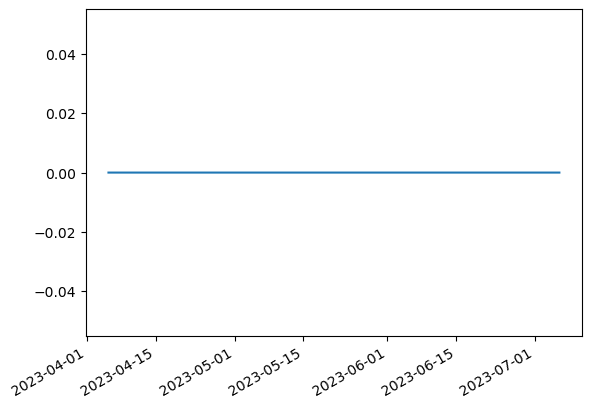

In [24]:
bt_res["cum_pnl"].plot()